###Brain MRI Segmentation:
A personal project in which I will be going through the process of using a U net model to predict the presence of brain tumor.

The dataset used is from this link: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

The jupyter notebook below has all the necessary information about the project.
In the end the model achieved an accuracy of 99.2% on the test set and all the results are visualized.

Written by: Hamza Imran Mirza

In [1]:
from google.colab import files

# Upload the kaggle.json file
files.upload()

# Move the file to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 95% 677M/714M [00:03<00:00, 51.3MB/s]
100% 714M/714M [00:03<00:00, 189MB/s] 


In [3]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm   #very helpful as it gives us a progress bar while we work with a lot of files
import tensorflow as tf

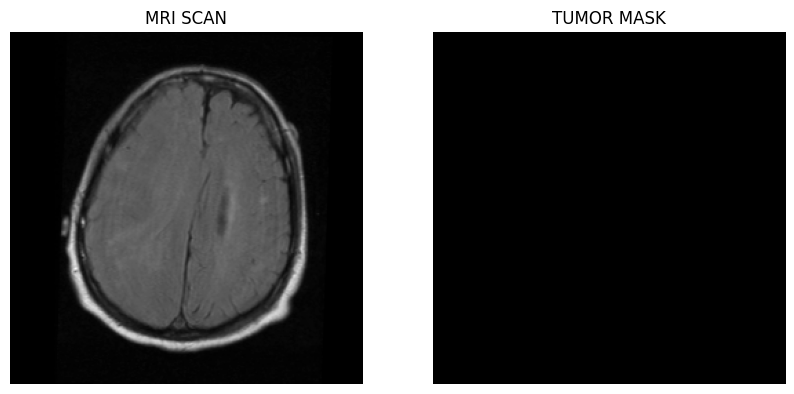

In [5]:
#Now we will try and visualize an image from the dataset and its corresponding Mask

patient_id = 'TCGA_CS_4944_20010208'
base_path = 'lgg-mri-segmentation/kaggle_3m' # Corrected base path
patient_path = os.path.join(base_path, patient_id)


#now we will construct the full paths to a specific image and its mask
image_name = f'{patient_id}_15.tif'
mask_name = f'{patient_id}_15_mask.tif' # Corrected variable name

image_path = os.path.join(patient_path, image_name)
mask_path = os.path.join(patient_path, mask_name) # Corrected variable name


#Loading the images
#we will be using grayscale so they are loaded as a single channel grayscaled images
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


# Check if images are loaded correctly
if image is None:
    print(f"Error: Could not load image from {image_path}")
elif mask is None:
    print(f"Error: Could not load mask from {mask_path}")
else:
    #Visualizing the images
    plt.figure(figsize=(10,5))


    #Subplot number 1 will be the original MRI image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("MRI SCAN")
    plt.axis('off')


    #Subplot number 2 will show the Tumor Mask
    plt.subplot(1, 2, 2) # Corrected subplot number
    plt.imshow(mask, cmap='gray')
    plt.title("TUMOR MASK")
    plt.axis('off')


    plt.show()

###PreProcessing
1. Iterating through all the files in the dataset
2. Resizing to make every image and mask a uniform size in the dataset so that the input to our neural network is always consistent
3. Normalizing by scaling the image pixel values from -[0, 255] to [0, 1]. Since the mask shows either tumor or no tumor so we can turn it into a binary -> 1 for tumor and 0 for background


In [6]:
#First we will define the constants and the paths
IMG_SIZE = 128
base_path = 'lgg-mri-segmentation/kaggle_3m'

#We will store our processed images in X array and masks in a Y array
X = []
y = []

#So, whenever we want to go through all the directories and files we can use os.walk
for dirpath, dirnames, filenames in tqdm.tqdm(os.walk(base_path)):
  for filename in filenames:

    #We would only want to process files that are NOT masks first
    if 'mask' not in filename:
      try:

        #Constructing the full path first
        image_path = os.path.join(dirpath, filename)
        mask_path = image_path.replace('.tif', '_mask.tif')

        #This is how you load the image and the mask
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if images are loaded correctly before processing
        #Added this check because without it cv2 would try to resize empty images and would through an error
        if image is not None and mask is not None:
            image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

            #Normalizing images and the mask
            X.append(image_resized/255.0)
            y.append(np.where(mask_resized > 0, 1.0, 0.0))
        else:
            # Optionally, print a message if a file couldn't be loaded
            # print(f"Skipping processing for {filename} as it could not be loaded.")
            pass


      except Exception as e:
        print(f"Error processing {filename}: {e}")


#Converting into a numpy array for better processing
X = np.array(X)
y = np.array(y)

#adding a channel dimension for TensorFlow
X  = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)


print(f"Shape of images (X): {X.shape}")
print(f"Shape of masks (y): {y.shape}")
print(f"Data type of X: {X.dtype}")
print(f"Data type of y: {y.dtype}")
print(f"Unique values in a sample mask: {np.unique(y[0])}")

111it [00:02, 42.22it/s]


Shape of images (X): (3929, 128, 128, 1)
Shape of masks (y): (3929, 128, 128, 1)
Data type of X: float64
Data type of y: float64
Unique values in a sample mask: [0.]


So basically what we did was to do the splitting in two steps
1. First we seperated out the test set from the data and named the remaining 90%  of the data as train + validate and the other 10% is our test set
2. Next we again seperated the big chunk of data into train data and validate data.

In [7]:
from sklearn.model_selection import train_test_split



#Splitting the dataset into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size= 0.1,
                                                            random_state=42 #setting this random state ensures that we get the same split every time)
)


#Splitting the training +validation set into final training and validation sets

#we will be splitting the 90% into a validation set of 10% of the original dataset
#So, the new tes_size is 0.1/0.9 = 0.111111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"-"*20)
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"-"*20)
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (3143, 128, 128, 1)
y_train shape: (3143, 128, 128, 1)
--------------------
X_val shape: (393, 128, 128, 1)
y_val shape: (393, 128, 128, 1)
--------------------
X_test shape: (393, 128, 128, 1)
y_test shape: (393, 128, 128, 1)


###Building the U-net Model

Our preprocessing is done and now we will build the U-net model.
Encoder would be a standard CNN
Decoder and they are directly connected to each other


Cheat Sheet for Building U net models:
## Step 1: Define the Input and Output
Before writing any code, know your data.

Input Shape: What is the size of your input images? It's best to resize them to be a power of 2 (e.g., 128x128, 256x256). This ensures clean divisions during downsampling. Note the number of channels (1 for grayscale, 3 for RGB).

Output Classes: How many things are you segmenting?

For binary segmentation (like our project: tumor vs. background), you need 1 output channel.

For multi-class segmentation (e.g., background vs. tumor vs. edema), you need one output channel per class.


## Step 2: Design the Encoder (The "Down" Path) 📉
This path extracts features and reduces spatial dimensions. For each level of the encoder:

Create a Convolutional Block: This typically consists of two Conv2D layers.

Use a consistent kernel size, usually (3, 3).

Use 'relu' as the activation function.

Use padding='same' to maintain the size within the block.

Consider adding Dropout after the convolutions for regularization.

Double the Filters: Follow the "power of 2" rule. If the first block has 16 filters, the next should have 32, then 64, and so on. This increases the model's capacity as it learns more complex features.

Downsample: After the convolutional block, add a MaxPooling2D((2, 2)) layer. This will halve the height and width of the feature map.

Save the Output: Store the output tensor of the convolutional block (before the MaxPooling) so you can use it later for the skip connection.

Repeat this process for as many levels as you need (typically 3-5).


Of course. Here is a step-by-step guide you can use as a checklist or cheat sheet whenever you're designing a U-Net architecture from scratch.

## Step 1: Define the Input and Output
Before writing any code, know your data.

Input Shape: What is the size of your input images? It's best to resize them to be a power of 2 (e.g., 128x128, 256x256). This ensures clean divisions during downsampling. Note the number of channels (1 for grayscale, 3 for RGB).

Output Classes: How many things are you segmenting?

For binary segmentation (like our project: tumor vs. background), you need 1 output channel.

For multi-class segmentation (e.g., background vs. tumor vs. edema), you need one output channel per class.

## Step 2: Design the Encoder (The "Down" Path) 📉
This path extracts features and reduces spatial dimensions. For each level of the encoder:

Create a Convolutional Block: This typically consists of two Conv2D layers.

Use a consistent kernel size, usually (3, 3).

Use 'relu' as the activation function.

Use padding='same' to maintain the size within the block.

Consider adding Dropout after the convolutions for regularization.

Double the Filters: Follow the "power of 2" rule. If the first block has 16 filters, the next should have 32, then 64, and so on. This increases the model's capacity as it learns more complex features.

Downsample: After the convolutional block, add a MaxPooling2D((2, 2)) layer. This will halve the height and width of the feature map.

Save the Output: Store the output tensor of the convolutional block (before the MaxPooling) so you can use it later for the skip connection.

Repeat this process for as many levels as you need (typically 3-5).

## Step 3: Create the Bottleneck
This is the bottom of the "U," where the feature map is smallest and most abstract.

It's simply another convolutional block (two Conv2D layers).

It does not have a MaxPooling layer after it.

It should have the highest number of filters in your network (e.g., 128, 256, etc.).


## Step 4: Design the Decoder (The "Up" Path) 📈
This path reconstructs the image and localizes features. For each level of the decoder (mirroring the encoder):

Upsample: Start with a Conv2DTranspose layer.

Use a (2, 2) kernel with strides=(2, 2). This will double the height and width.

Halve the number of filters compared to the layer below it (e.g., from 64 back to 32).

Add the Skip Connection: Use a concatenate layer to merge the upsampled output with the corresponding saved output from the encoder. This is the most critical step in the U-Net.

Create a Convolutional Block: Just like in the encoder, apply two Conv2D layers (with 'relu' activation) to process the merged feature map.

Repeat this until you get back to the original image size.


## Step 5: Build the Output Layer
This is the final layer that generates the segmentation mask.

It's a single Conv2D layer with a (1, 1) kernel.

The number of filters must match your output classes (1 for binary, N for multi-class).

The activation function is critical:

Use 'sigmoid' for binary segmentation.

Use 'softmax' for multi-class segmentation.



## U-Net Cheat Sheet
Symmetry: The encoder and decoder paths should be symmetrical.

Power of 2: Input image size (128, 256) and filter counts (16, 32, 64...) should follow powers of 2.

Skip Connections: Always connect encoder and decoder layers of the same spatial size.

Final Activation: 'sigmoid' for two classes, 'softmax' for more than two.


For this U net model the patter of layers goes as
1. Conv2D layer to learn features
2. Dropout layer for regularization
3. Another Conv2D layer to learn more complex features based on the first layer's output.

In [8]:
def build_unet(input_shape):

  #This function will build a U-net model using Keras Functional API
  inputs = tf.keras.layers.Input(shape= input_shape)


  #Defining the Encoder, the contracting path
  #Block 1:
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1  = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  #Block 2:
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)


  #Bottleneck
  c_middle = tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", kernel_initializer="he_normal", padding='same')(p2)
  c_middle = tf.keras.layers.Dropout(0.2)(c_middle)
  c_middle = tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", kernel_initializer="he_normal", padding='same')(c_middle)


  #Decoder, the expanding path
  #Block 3:
  u3 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c_middle)
  u3 = tf.keras.layers.concatenate([u3, c2])   #This is the skip connection
  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", kernel_initializer="he_normal", padding='same')(u3)
  c3 = tf.keras.layers.Dropout(0.1)(c3)
  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu', kernel_initializer='he_normal', padding='same')(c3)


  #Block 4:
  u4 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2, 2), padding = 'same')(c3)
  u4 = tf.keras.layers.concatenate([u4, c1])
  c4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
  c4 = tf.keras.layers.Dropout(0.1)(c4)
  c4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)


  #Output Layer
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = "sigmoid")(c4)

  #Creating the model
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

  return model

#Instantiating and Inspecting the Model
#Here the input shape would be the IMG_SIZE

input_shape = (IMG_SIZE, IMG_SIZE, 1)
model = build_unet(input_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_3[0][0] 

 Total params: 116,753 (456.07 KB)

 Trainable params: 116,753 (456.07 KB)

 Non-trainable params: 0 (0.00 B)

The next step would be to compile the model.
Basically compiling is like giving the model its learning instructions and we need to tell it three things:
1. The optimizer, the algo to use to update its internal parameteres to reduce errors.
2. The loss function, to measure the error between the model's prediction and the true mask.
3. The metrics, what scores to tracks and display during training to judge the performance.

###Dice Coefficient
For segmentation tasks, standard "accuracy" can be misleading. A model could achieve 99% accuracy by correctly predicting all the background pixels while completely missing a small tumor.

A much better metric is the Dice Coefficient, which measures the overlap between the predicted mask and the true mask. A score of 1.0 means a perfect overlap, and 0 means no overlap. We'll write a custom function for this.


In [9]:
from tensorflow.keras import backend as K

In [10]:
#This will be a custom metric that we will monitor during training
def dice_coef(y_true, y_pred, smooth=1):

  #calculating the dice coefficient, a measure of overlap between two samples.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


#Compiling the model
model.compile(optimizer='adam',   #adam is the go to optimizer for most deep learning tasks
              loss = 'binary_crossentropy',
              metrics=[dice_coef, 'accuracy'])

print("This model was compiled successfully")

This model was compiled successfully


The obvious next step would be to train the model.

In [11]:
#We will define callbacks
#Tools that monitor the training processes.

#Model Checkpoint will save the best version of the model
#It will save onlyl when the dice coeff improves

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras',
                                                monitor='val_dice_coef',
                                                save_best_only=True,
                                                mode ='max',
                                                verbose=1)

#To train the model efficiently we will stop training early if the model stops improving
#If dice_coef does not improve in 5 straight epochs we will stop the training

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef',
                                                  patience=5,
                                                  mode='max',
                                                  restore_best_weights=True,
                                                  verbose=1)

#Training the model
#We pass the data, batch size, epochs and callbacks

history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)

print("Training Completed")

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9680 - dice_coef: 0.0412 - loss: 0.1565
Epoch 1: val_dice_coef improved from -inf to 0.12591, saving model to best_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.9680 - dice_coef: 0.0413 - loss: 0.1561 - val_accuracy: 0.9880 - val_dice_coef: 0.1259 - val_loss: 0.0540
Epoch 2/50
195/197 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9893 - dice_coef: 0.0966 - loss: 0.0398
Epoch 2: val_dice_coef improved from 0.12591 to 0.15443, saving model to best_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9893 - dice_coef: 0.0966 - loss: 0.0398 - val_accuracy: 0.9880 - val_dice_coef: 0.1544 - val_loss: 0.0409
Epoch 3/50
195/197 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9887 - dice_coef: 0.1126 - loss: 0.0401
Epoch 3: val_dice_coef improved from 0.15443 to 0.18654, saving model to best_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9887 - dice_coef: 0.1127 - los

Next step would be to visualize training history and Evaluate the final model on the test set and see the unbiased scode and visualize the predictions   

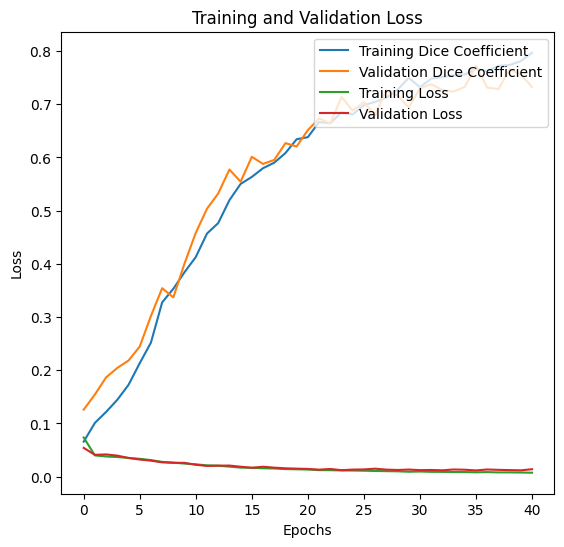

In [12]:
import matplotlib.pyplot as plt

#Since all of our training data is stored in the history object.
#We will extract that data

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(len(dice))


#Next we will create the plots
plt.figure(figsize=(14, 6))

#Plot for the dice coefficient
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Coefficient')
plt.plot(epochs_range, val_dice, label='Validation Dice Coefficient')
plt.legend(loc='lower right')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')


#Plot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [13]:
#After the training is done, We will load in the best saved model
best_model = tf.keras.models.load_model('best_model.keras', custom_objects={'dice_coef': dice_coef})

#Evaluate on the test set
test_loss, test_dice, test_accuracy = best_model.evaluate(X_test, y_test)


print(f"\nTest Set Performance: ")
print(f"Loss: {test_loss:.4f}")
print(f"Dice Coefficient: {test_dice:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9963 - dice_coef: 0.7825 - loss: 0.0108

Test Set Performance: 
Loss: 0.0108
Dice Coefficient: 0.7435
Accuracy: 0.9963


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


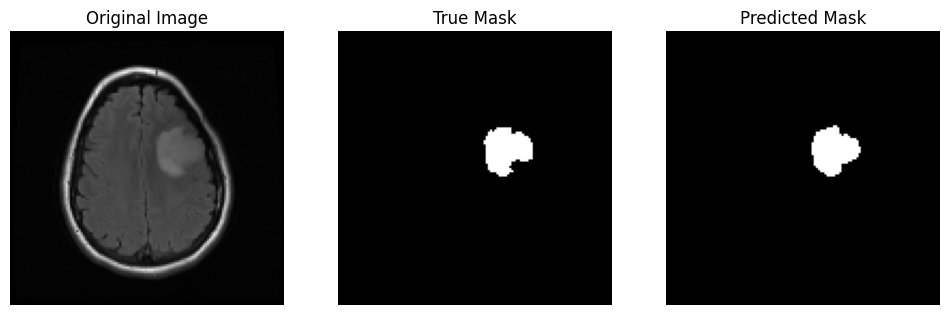

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


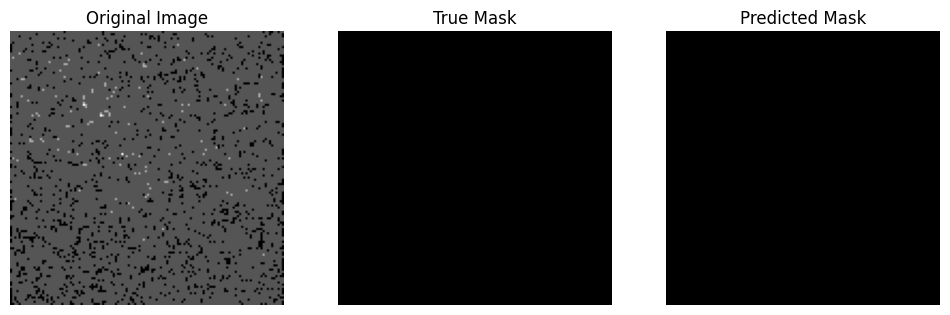

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


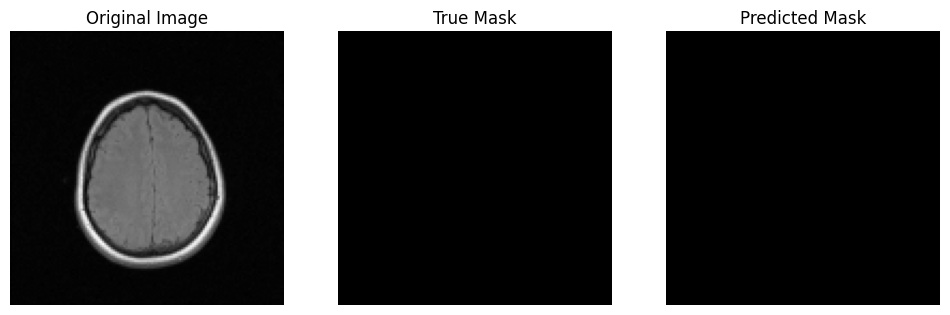

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


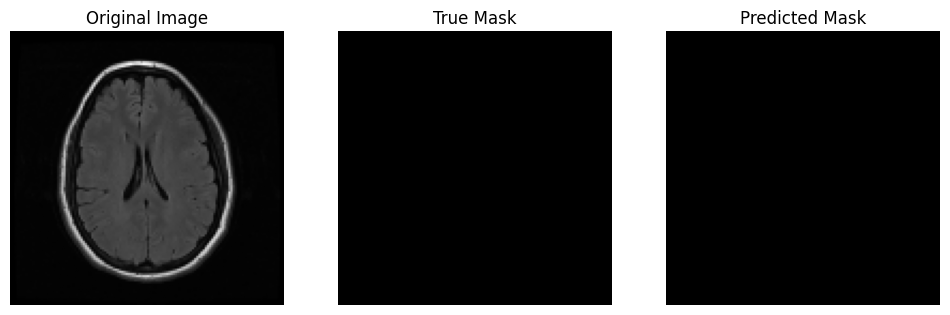

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


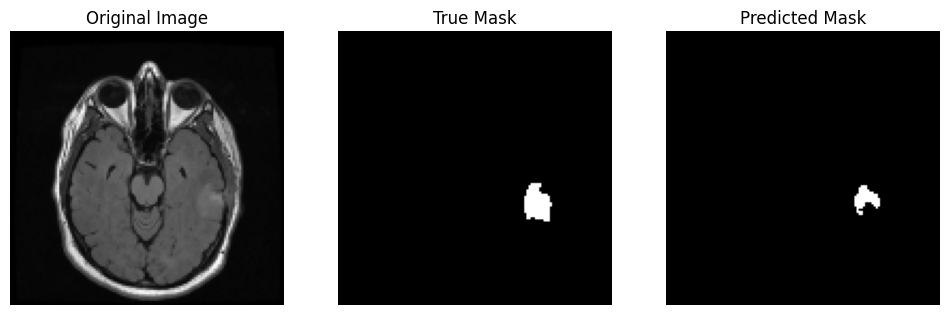

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


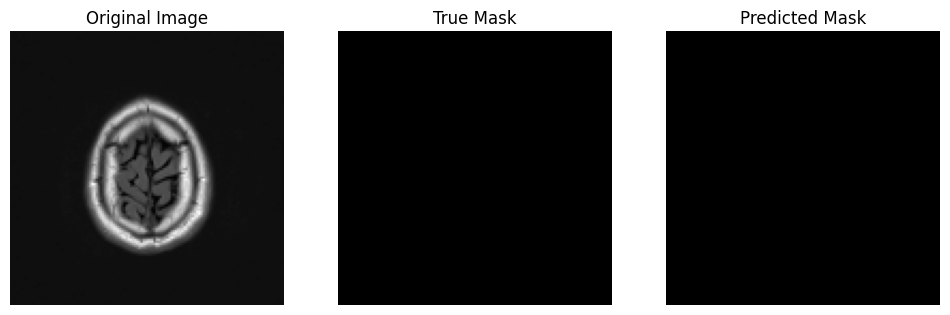

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


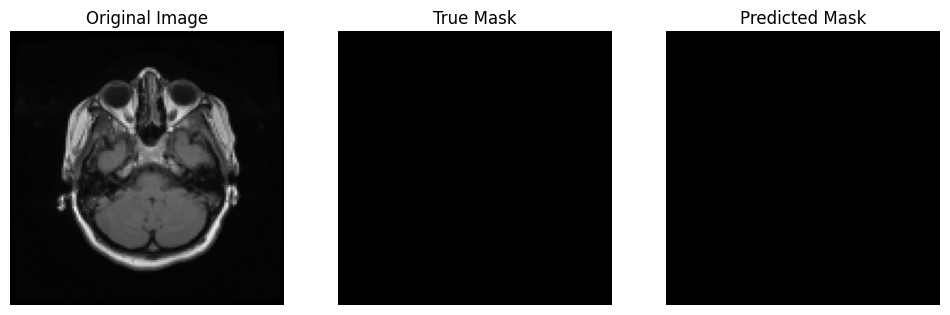

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


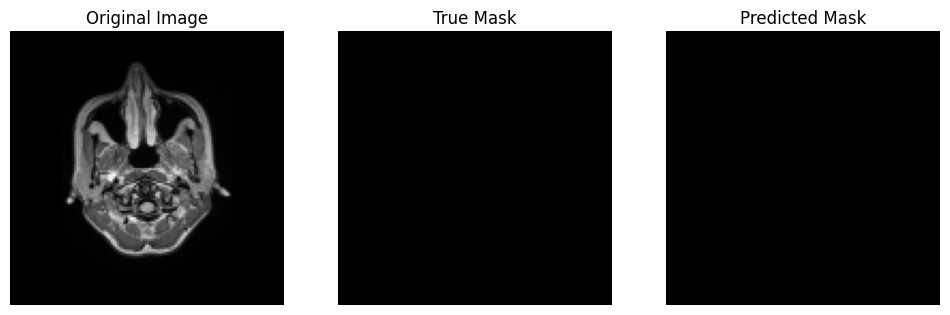

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


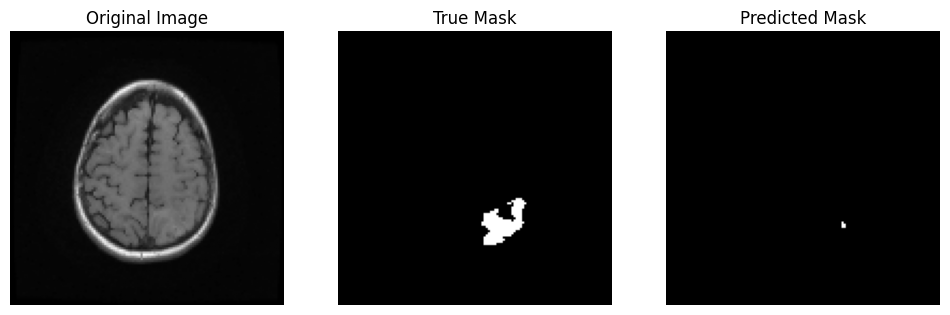

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


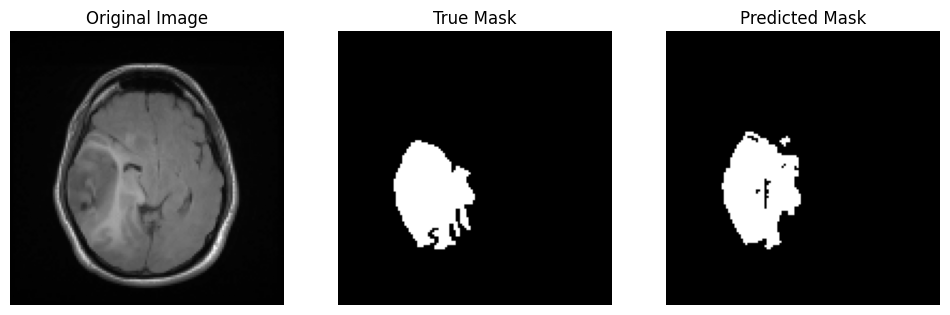

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


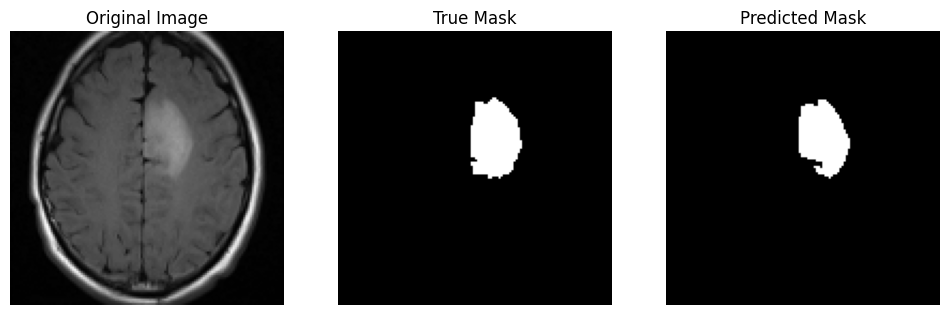

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


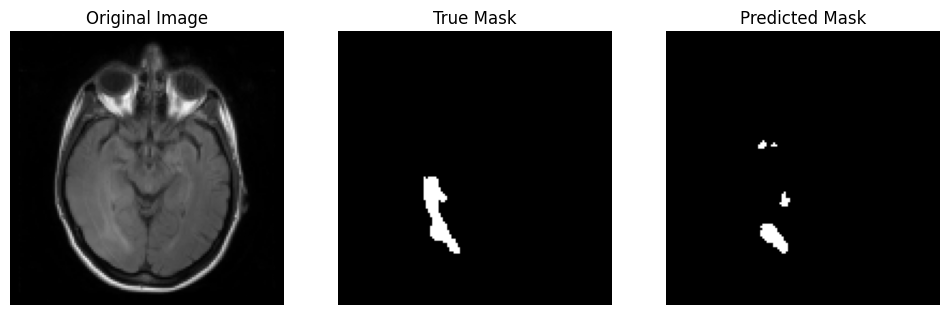

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


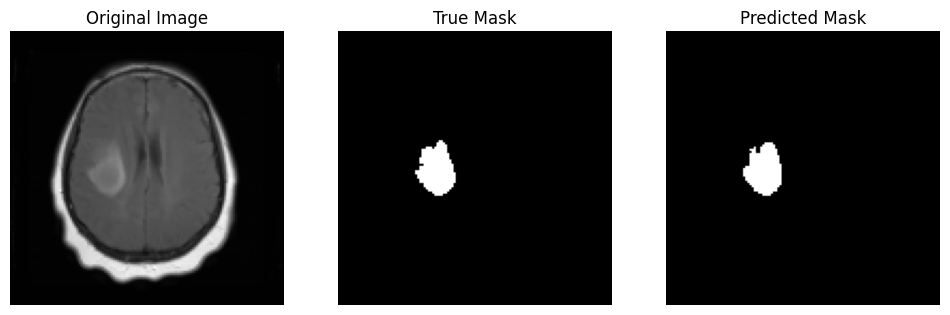

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


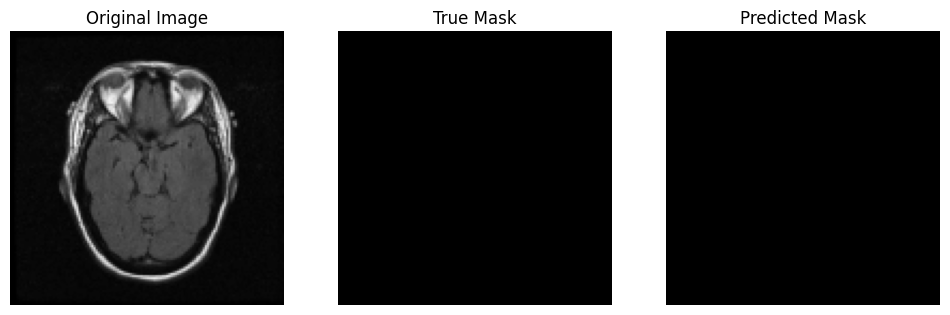

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


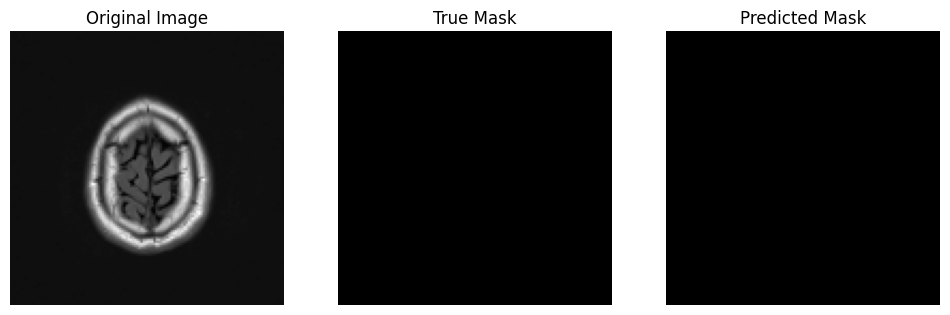

In [17]:
#Lastly, we will visualize all of  the predictions

import random

#Make predictions on a few reandom test images

num_sample_to_show = 15

for _ in range(num_sample_to_show):

  #Selecting a random index
  idx = random.randint(0, len(X_test)-1)

  #Get the single image and its true mask
  image = X_test[idx]
  true_mask = y_test[idx]

  #Predict the mask, We need to add a batch dimension for the model to predict a single image
  predicted_mask = best_model.predict(np.expand_dims(image, axis=0))[0]

  plt.figure(figsize=(12, 4))

  # Original Image
  plt.subplot(1, 3, 1)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  # True Mask
  plt.subplot(1, 3, 2)
  plt.imshow(true_mask.squeeze(), cmap='gray')
  plt.title('True Mask')
  plt.axis('off')

  # Predicted Mask
  plt.subplot(1, 3, 3)
  # We use a threshold of 0.5 to get a binary mask from the sigmoid output
  plt.imshow(predicted_mask.squeeze() > 0.5, cmap='gray')
  plt.title('Predicted Mask')
  plt.axis('off')

  plt.show()